## Классификация  

Прогнозирование эффективности маркетинговой кампании банка

### Импорты и чтение данных

In [1]:
# импортирую библиотеки

import collections
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
import seaborn as sns

# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

# настройки отображения строк и столбцов в пандас
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)

# настройка стиля графиков
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# чтение данных

df = pd.read_csv('data/bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# закодирую целевую переменную

le = LabelEncoder()
df['deposit'] = le.fit_transform(df['deposit'])

In [4]:
# выведу долю пропусков по столбцам

def missing_values(data):
    """
    Возвращает только колонки с пропусками:
    - общее число пропущенных значений
    - доля пропусков
    """
    missing = pd.DataFrame(df.isnull().sum())
    missing['% of Total Values'] = 100 * df.isnull().sum() / len(df)
    missing.rename(columns = {0 : 'Missing Values'}, inplace=True)
    missing.sort_values(by='% of Total Values', ascending=False, inplace=True)
    missing = missing[missing['Missing Values']>0]
    
    return missing

missing_values(df)

,Missing Values,% of Total Values


Пропусков в датасете нет.

### Визуальный анализ данных

In [5]:
def feature_stat(data, feature, target):
    """
    Выводит гистограмму и среднее значение целевой
    по группе.
    Подходит для категориальных переменных
    """
    x = [i for i in data.groupby(feature)[target].count().index]
    
    y_cnt = [i for i in data.groupby(feature)[target].count().values]
    y_mean = [i for i in data.groupby(feature)[target].mean().values]
    ind = np.arange(len(data[feature].unique()))
    
    fig, ax1 = plt.subplots()
    ax1.bar(ind, y_cnt, align='center', width=0.4, alpha=0.7)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Counts', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(ind, y_mean, 'r')
    ax2.set_ylabel('Target mean rate', color='r')
    ax2.tick_params('y', colors='r')
    plt.xticks(ind, x, rotation=45)
    plt.title('{} and target'.format(feature))
    ax1.set_xticklabels(x, rotation=35)
    plt.grid(False)
    plt.show()

    
def get_columns_types(dataframe):
    """
    Выделяет количественные и номинативные переменные
    """
    cat, num = list(), list()
    cat = [column for column in df.columns if df[column].dtype == 'object']
    num = [column for column in df.columns if column not in cat]
    
    return cat, num

cat, num = get_columns_types(df)

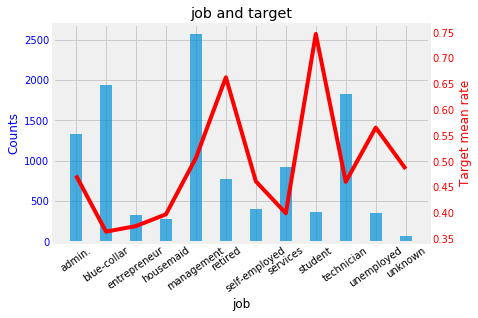

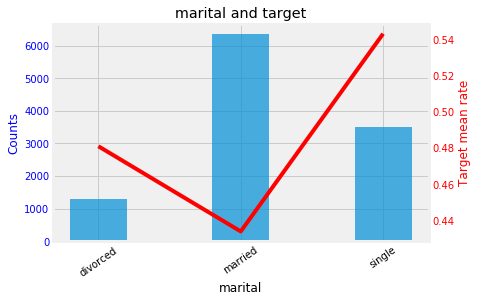

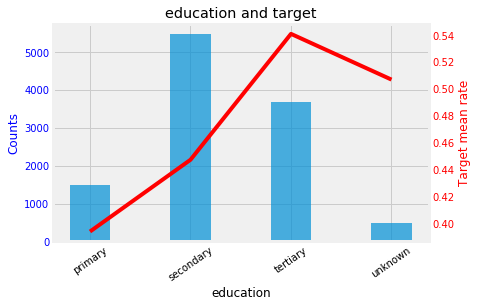

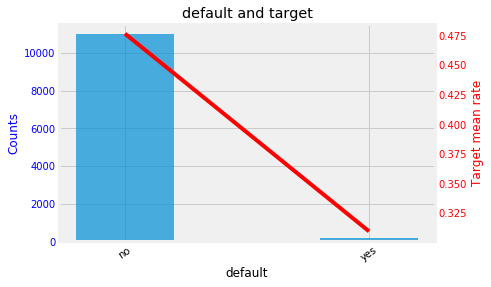

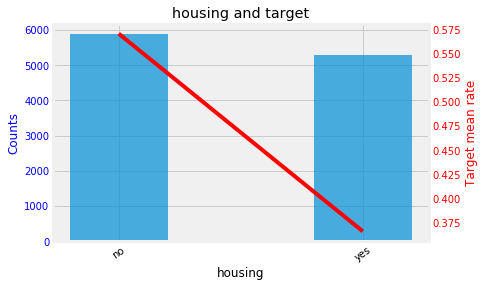

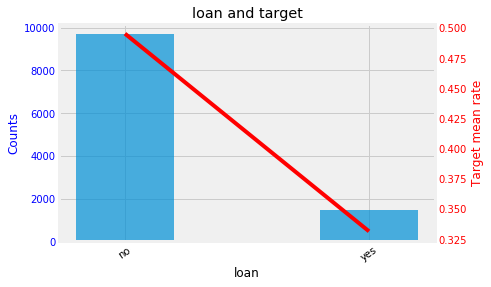

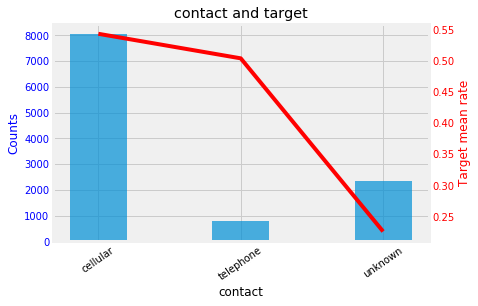

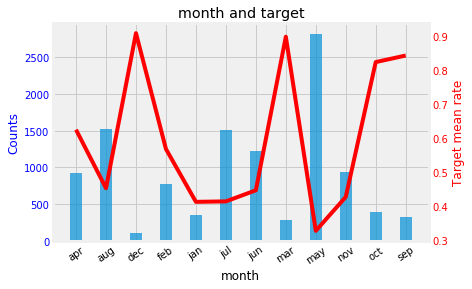

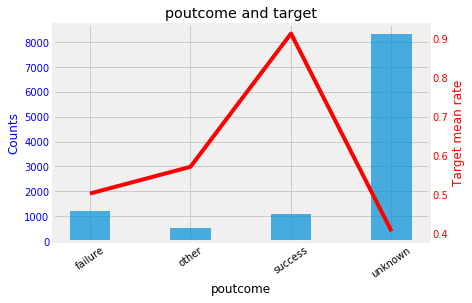

In [6]:
for feature in cat:
    feature_stat(df, feature, 'deposit')

Для переменной job объединю в одну категорию other несколько категорий с небольшим кол-вом наблюдений:

In [7]:
tmp = df['job'].value_counts(normalize=True)
to_remove = [e for i, e in enumerate(tmp.index) if tmp.values[i] < 0.05]
df.loc[df['job'].isin(to_remove) == True, 'job'] = 'Others'

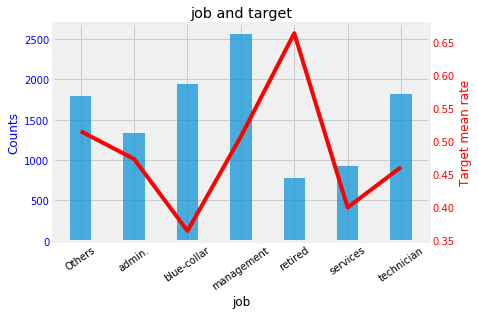

In [8]:
# посмотрим что получилось

feature_stat(df, 'job', 'deposit')

Аналогично поступлю для месяца:

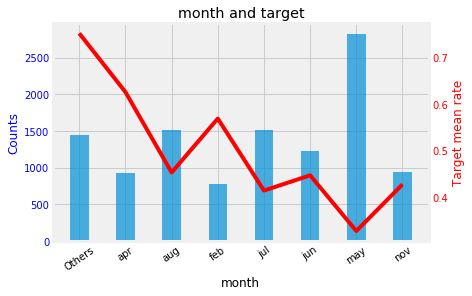

In [9]:
tmp = df['month'].value_counts(normalize=True)
to_remove = [e for i, e in enumerate(tmp.index) if tmp.values[i] < 0.05]
df.loc[df['month'].isin(to_remove) == True, 'month'] = 'Others'

feature_stat(df, 'month', 'deposit')

Стоит отметить, что я разделил признаки по принципу "как есть в датафрейме". Посмотрю на кол-во уникальных значений в num колонках:

In [10]:
for feature in num:
    if feature != 'deposit':
        print(feature, df[feature].nunique())

age 76
balance 3805
day 31
duration 1428
campaign 36
pdays 472
previous 34


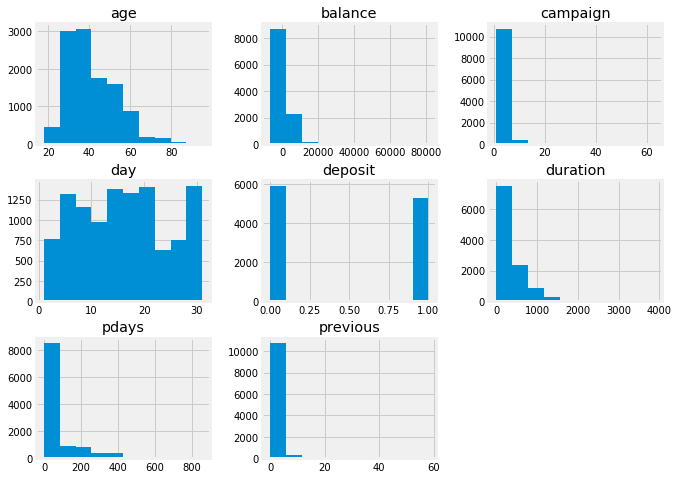

In [11]:
# построю базовые гистограммы


df[num].hist(figsize=(10,8));

Заметим, что среди признаков есть duration - длительность звонка, которая, очевидно, будет неизвестна для будущих коммуникаций.  
Следовательно, этот признак стоит удалить.

In [12]:
df = df.drop('duration', axis=1)

Фича campaign показывает кол-во контактов во время тек. кампании.  
Для удобства анализа, размечу всех клиентов с более чем 5-ю контактами как 5.

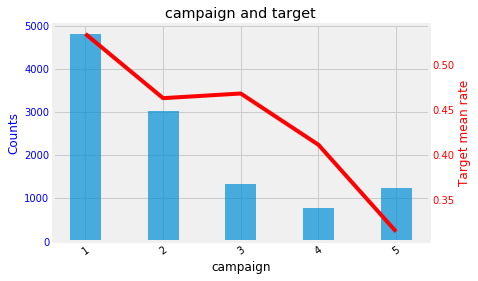

In [13]:
df.loc[df['campaign']>5, 'campaign'] = 5
feature_stat(df, 'campaign', 'deposit')

С переменной previous поступлю аналогично:

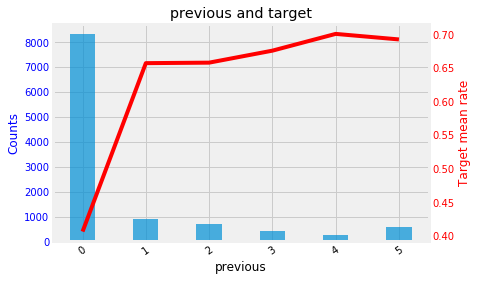

In [14]:
df.loc[df['previous']>5, 'previous'] = 5
feature_stat(df, 'previous', 'deposit')

Кажется, что дисбаланс слишком велик и стоит сделать previous бинарым признаком:

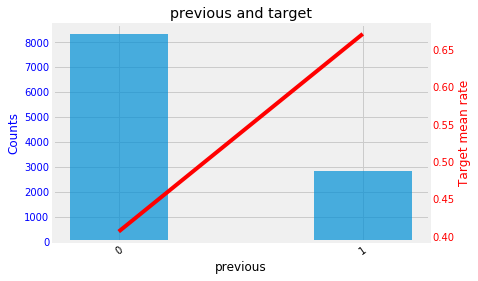

In [15]:
df.loc[df['previous']>1, 'previous'] = 1
feature_stat(df, 'previous', 'deposit')

pdays - число дней с предыдущего контакта.  
Сделаю переменную бинарной: предыдущий контакт был или нет.

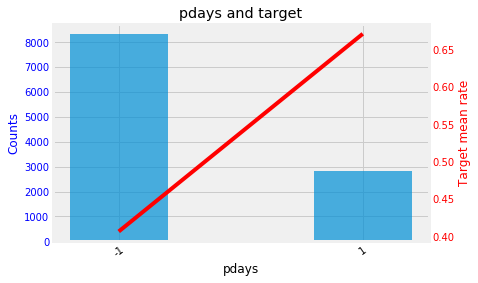

In [16]:
df.loc[df['pdays']>1, 'pdays'] = 1
feature_stat(df, 'pdays', 'deposit')

Видим что получили точно такое же распределение.  
Убедимся:

In [17]:
df['pdays'].corr(df['previous'])

1.0

Удалю сразу одну из них:

In [18]:
df = df.drop('pdays', axis=1)

In [19]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,0,unknown,1


Перейдем к количественным переменным, пусть их немного:

In [20]:
# удалим переменные, которые оказались номинативными 

for feature in ['pdays','previous','deposit', 'duration', 'campaign']:
    num.remove(feature)
    
num

['age', 'balance', 'day']

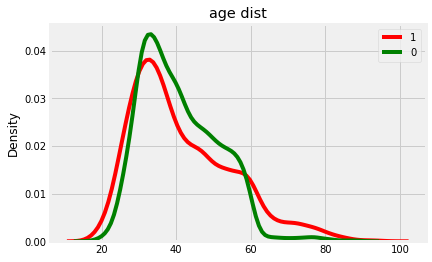

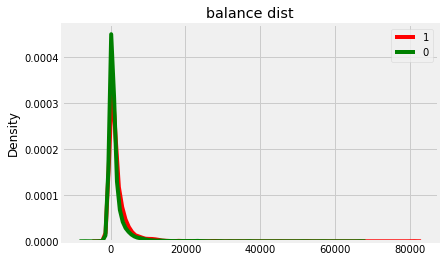

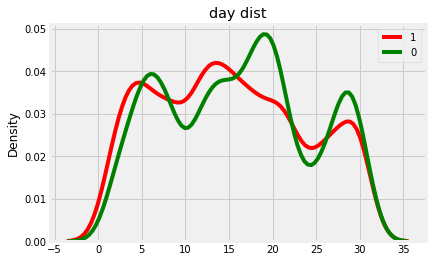

In [21]:
def dist_plot(data, feature, target):
    
    sns.kdeplot(data[data[target] == 1][feature], label = '1', color = 'red')
    sns.kdeplot(data[data[target] == 0][feature], label = '0', color = 'green')
    
    plt.ylabel('Density')
    plt.title(feature + ' dist')
    plt.show()
    

for feature in num:
    dist_plot(df, feature, 'deposit')

C возрастом интересно, больший отклик у молодых и у пожилых. 

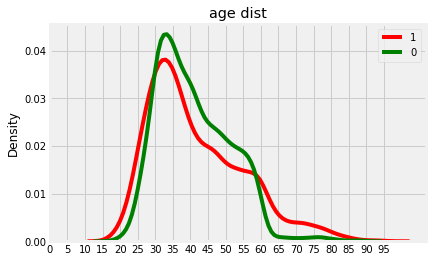

In [22]:
sns.kdeplot(df[df['deposit'] == 1]['age'], label = '1', color = 'red')
sns.kdeplot(df[df['deposit'] == 0]['age'], label = '0', color = 'green')
    
plt.ylabel('Density')
plt.title('age' + ' dist')
plt.xticks(np.arange(0,100,5))
plt.show()

In [23]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,0,unknown,1


### Генерация новых признаков

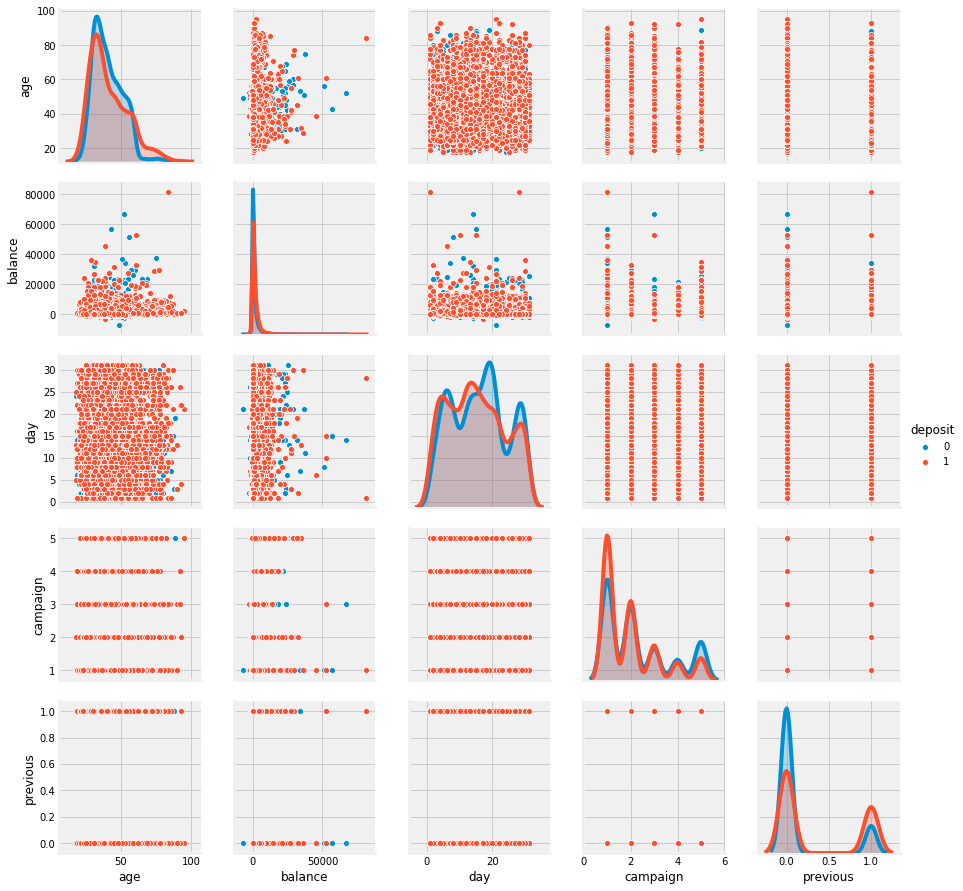

In [24]:
sns.pairplot(df, hue='deposit', vars = ['age',  'balance',  'day', 'campaign', 'previous'])

In [25]:
from itertools import combinations
feature_pais = list(combinations(['job',
 'marital',
 'education',
 'default',
 'loan',
],2))

In [26]:
for pair in feature_pais:
    print(pd.crosstab(df[pair[0]], df[pair[1]], values = df['deposit'], aggfunc=np.mean))
    print('==============================')

marital      divorced   married    single
job                                      
Others       0.471910  0.396205  0.673611
admin.       0.494505  0.451994  0.494737
blue-collar  0.389262  0.327341  0.463043
management   0.493056  0.476891  0.562353
retired      0.707602  0.657487  0.500000
services     0.413223  0.353175  0.473154
technician   0.377451  0.447312  0.503628
education     primary  secondary  tertiary   unknown
job                                                 
Others       0.400673   0.516255  0.562823  0.551020
admin.       0.285714   0.463100  0.589286  0.450000
blue-collar  0.314121   0.387993  0.500000  0.383721
management   0.333333   0.407563  0.520661  0.571429
retired      0.642599   0.659236  0.721429  0.638298
services     0.349398   0.396783  0.471698  0.463415
technician   0.317073   0.428453  0.548944  0.442308
default            no       yes
job                            
Others       0.519340  0.305556
admin.       0.474679  0.272727
blue-collar  0.36

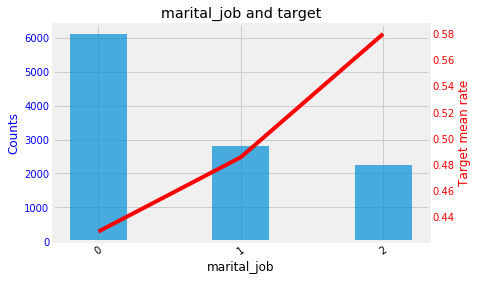

In [27]:
# сгенерирую признак семейного положения и профессии

df['marital_job'] = 0

# выделю те категории, где средний отклик ниже 40%

df.loc[(df['marital']=='married') & df['job'].isin(['blue_collar', 'technician', 'Others']), 'marital_job'] = 1
df.loc[(df['marital']=='divorced') & df['job'].isin(['blue_collar', 'technician']), 'marital_job'] = 1


# выделю те категории, где средний отклик выше 50%

df.loc[df['job'].isin(['retired']), 'marital_job'] = 1
df.loc[(df['marital']=='single') & df['job'].isin(['management', 'technician', 'Others']), 'marital_job'] = 2


feature_stat(df, 'marital_job', 'deposit')

На первый взгляд неплохо. Оставлю этот признак.

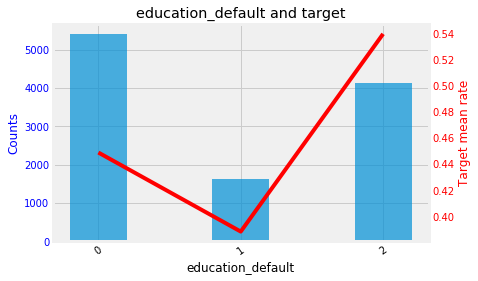

In [28]:
# сгенерирую признак образования и наличия дефолта

df['education_default'] = 0

# выделю те категории, где средний отклик ниже 40%

df.loc[(df['default']=='yes') & df['education'].isin(['primary', 'tertiary', 'secondary']), 'education_default'] = 1
df.loc[(df['default']=='no') & df['education'].isin(['primary']), 'education_default'] = 1



# выделю те категории, где средний отклик выше 50%

df.loc[(df['default']=='no') & df['education'].isin(['tertiary', 'unknown']), 'education_default'] = 2




feature_stat(df, 'education_default', 'deposit')

Тоже неплохо. Оставлю и этот признак.

In [29]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,poutcome,deposit,marital_job,education_default
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,0,unknown,1,0,0
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,0,unknown,1,0,0
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,0,unknown,1,1,0
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,0,unknown,1,0,0
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,0,unknown,1,0,2


### Препроцессинг данных

In [30]:
# удалю дубликаты

df = df.drop_duplicates()

# закодирую категориальные переменные

for feature in cat:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

In [31]:
# разделю датасет на таргет и признаки

X = df.drop('deposit', axis=1)
y = df['deposit']

# воспроизводимость
rs = np.random.seed(0)

# разобью данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=rs, stratify=y)


In [32]:
# стандартизация данных

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Обучение модели  

Обучать буду случайный лес, параметры подбирать с помощью GridSearchCV.

In [33]:
# гиперпараметры случайного леса

params = {'n_estimators' : [10, 30, 150],
                  'criterion' : ['entropy', 'gini'],
                  'max_features' : ['sqrt', None],
                  'max_depth' : [5, 10, None],
                  'min_samples_split' : [2, 15],
                  'max_leaf_nodes' : [100, None],
                 }


# подбор гиперпараметров

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(), 
    scoring = 'roc_auc',
    param_grid=params,
    cv=5,
    n_jobs=-1 # использую все ядра
    
)

rf_grid.fit(X_train, y_train)
clf = rf_grid.best_estimator_
print('RF best score: {}'.format(rf_grid.best_score_))

RF best score: 0.7757456008946177


### Оценка результатов

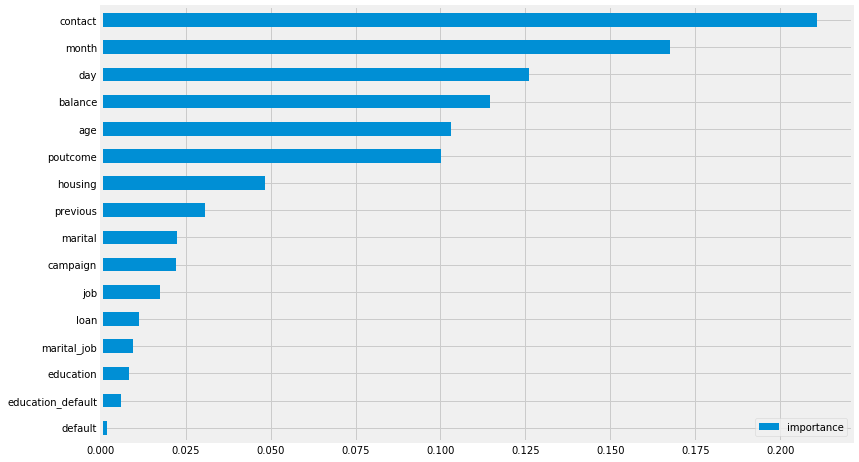

In [34]:
# выведу важность признаков

imp = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

In [35]:
pred_prob = clf.predict_proba(X_test)[:,1]
print('ROC-AUC score is {}'.format(roc_auc_score(y_test, pred_prob)))

ROC-AUC score is 0.7881063683435996


In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    '''
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

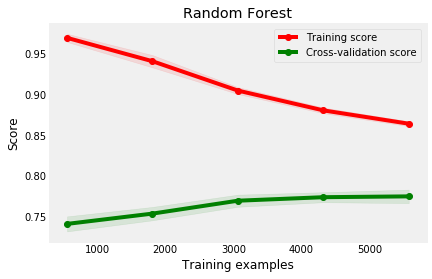

In [37]:
plot_learning_curve(clf, 'Random Forest', X_train, y_train, cv=3, n_jobs=-1);